
# 章節 5 選擇目標市場程式實作

author: 鍾皓軒 （臺灣行銷研究有限公司創辦人）

## 主題如下：
* 產品：A 公司主打的線上服務P 產品。
* 通路：100％的網路媒體。
* 價格：$ 5,000 元新台幣/ 每套。
* 成本：$ 884 元新台幣/ 每套。
* 行銷成本（內含行銷人員的人事成本）：$ 500 元新台幣 / 每位顧客。
* 銷售：A 公司先行提供30 天的免費線上服務 — P 產品，期望顧客能在期限
內正式簽約購買P 產品。
* 資料蒐集：目前已蒐集個別天數的每一消費者的實際購買狀況（購買 = 1；
未購買 = 0），這裡提供的是10,000 位顧客在使用第7 天時，購買狀況之
資料集

## 資料

可以從此[下載資料](https://github.com/HowardNTUST/Marketing-Data-Science-Application/blob/master/contract/contract.csv)

### 目標變數（或稱依變數）：
購買與否：每一客戶對P 商品的購買狀態，購買=1；未購買 = 0。

### 標籤（或稱自變數）：
* 產品使用分數 — 依據A 公司估算，每位顧客每天使用產品的流暢程度。
* 使用者所在地區 — 台北、台中與台南三個地區之資料。
* 性別— 男、女類別變數。
* 年齡 — 使用者年齡。
* 使用累計時間 — 使用者使用A 公司任一產品的時間。
* 點數餘額 — 使用者對A 公司產品總點數餘額。
* 產品服務使用量 — 使用者每天產品使用程度。
* 是否使用信用卡支付月費 — 使用者支付方式是否為信用卡。
* 是否為活躍用戶 — 使用者在A 公司的評估中，是否為活躍1 使用者。
* 估計薪資 — 使用者在A 公司的評估中，所估計的可用所得。

## 機器學習套件使用版本
套件使用版本之異同及機器學習模型參數之調整，將可能造成後續計算之預期獲利有所差異
* xgboost==0.90
* lightgbm==2.2.3




In [1]:

# 載入必要套件
# Importing the libraries
#from util import get_dummies
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, roc_curve, auc

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False  
from matplotlib.font_manager import FontProperties 
import seaborn as sns 
myfont=FontProperties(fname='Microsoft JhengHei',size=14) 
sns.set(font=myfont.get_family()) 
sns.set_style("darkgrid",{"font.sans-serif":['Microsoft JhengHei']}) 


## 載入資料

In [2]:

data = pd.read_csv('contract.csv')


In [3]:
data

,產品使用分數,使用者地區,性別,年齡,使用累計時間,點數餘額,產品服務使用量,是否使用信用卡付月費,是否為活躍用戶,估計薪資,購買與否
0,619,Taipei,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Tainan,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,Taipei,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,Taipei,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Tainan,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,Taipei,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,Taipei,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,Taipei,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Taichung,Male,42,3,75075.31,2,1,0,92888.52,1


## 資料檢視
接著進行初步分析，發現這10,000 筆資料中，購買者與不購買者呈現20/80 的
比例分佈（如圖5-2 所示，購買比例20.37 %；未購買比例79.63 %。），此為
「不平衡資料集（imbalanced dataset）」。不過，先不考慮不平衡資料集所可
能造成的問題，直接以三種演算法進行預測性建模。

不購買 79.63 % of the dataset
購買 20.37 % of the dataset


Text(0.5, 1.0, '購買與否 Distributions \n (0:不購買|| 1:購買 )')

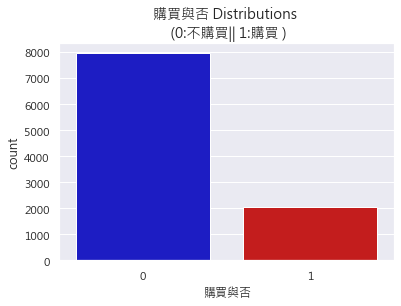

In [4]:

# The 購買與否es are heavily skewed we need to solve this issue later.
print('不購買', round(data['購買與否'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('購買', round(data['購買與否'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

# 看看y變數的分佈
colors = ["#0101DF", "#DF0101"]
sns.countplot('購買與否', data=data, palette=colors)
plt.title('購買與否 Distributions \n (0:不購買|| 1:購買 )', fontsize=14)


## 獨熱編碼（One-HotEncoding）轉換

In [5]:
# 獨熱編碼（One-HotEncoding）（如圖5-3 所示），將資料轉換為下述的資料型態
# 若有興趣的讀者，可以到本github資料夾裏面的contract_analysis_function查看開源程式碼
from contract_analysis_function import get_dummies

# get_dummies
dataset = get_dummies(['使用者地區', '性別'],data)


In [6]:
dataset

,產品使用分數,年齡,使用累計時間,點數餘額,產品服務使用量,是否使用信用卡付月費,是否為活躍用戶,估計薪資,購買與否,使用者地區_Taichung,使用者地區_Tainan,使用者地區_Taipei,性別_Female,性別_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,1,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,1,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,1,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,0,0,1,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,0,0,0,1,0,1
9997,709,36,7,0.00,1,0,1,42085.58,1,0,0,1,1,0
9998,772,42,3,75075.31,2,1,0,92888.52,1,1,0,0,0,1


## 切分Training set 與testing set

In [7]:

# split training and testing set
X =dataset.drop(columns=['購買與否'])
y =dataset['購買與否']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) 


## 建模
建模的同時，也將
* confusion matrix
* 模型檔案
兩者輸出，方便往後實戰「精準行銷模型」評估預期獲利所用


In [8]:
# 導入model function，來進行建模
from contract_analysis_function import model

### Random Forest（RF）

Training Accuracy = 1.000
Test Accuracy = 0.870
[[1528   67]
 [ 193  212]]
____________________Random Forest分類報告____________________
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1595
           1       0.76      0.52      0.62       405

    accuracy                           0.87      2000
   macro avg       0.82      0.74      0.77      2000
weighted avg       0.86      0.87      0.86      2000



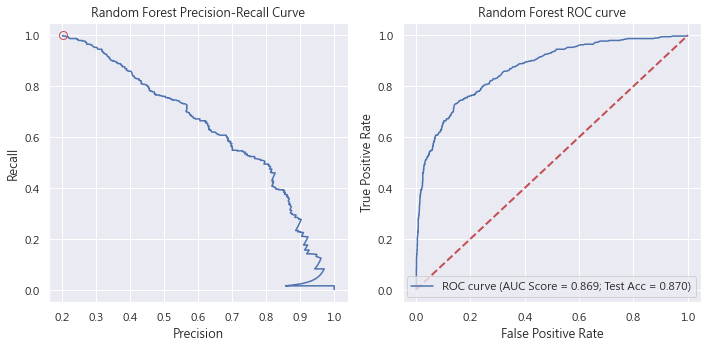

In [9]:
rf_confusion_matrix, rf_model = model(RandomForestClassifier(random_state = 0,n_estimators = 1000), 'Random Forest',X_train,y_train,X_test,y_test)

### XGBoost（XGB）

Training Accuracy = 0.885
Test Accuracy = 0.868
[[1522   73]
 [ 192  213]]
____________________xgboost分類報告____________________
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1595
           1       0.74      0.53      0.62       405

    accuracy                           0.87      2000
   macro avg       0.82      0.74      0.77      2000
weighted avg       0.86      0.87      0.86      2000



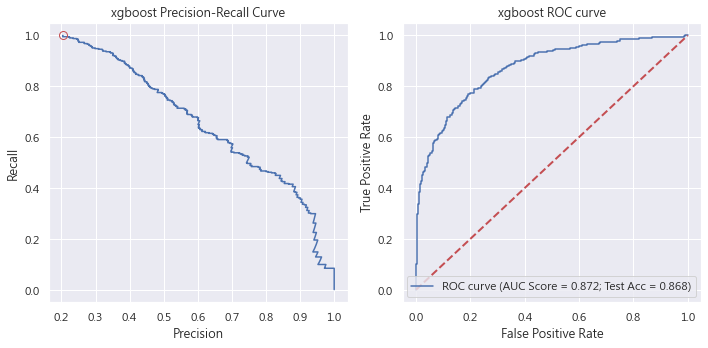

In [10]:
xgb_confusion_matrix, xgb_model= model(XGBClassifier(n_estimators=300 ,random_state = 0,nthread = 8), 'xgboost',X_train,y_train,X_test,y_test)

### LightGBM（LGBM）
請特別注意lightgbm目前最新版本的2.3.1（2020/08記錄）無法處理中文字，所以建議downgrade到2.2.3版本，可以使用 pip install lightgbm==2.2.3，完成重新安裝後

Training Accuracy = 1.000
Test Accuracy = 0.847
[[1487  108]
 [ 199  206]]
____________________LGBMClassifier分類報告____________________
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      1595
           1       0.66      0.51      0.57       405

    accuracy                           0.85      2000
   macro avg       0.77      0.72      0.74      2000
weighted avg       0.84      0.85      0.84      2000



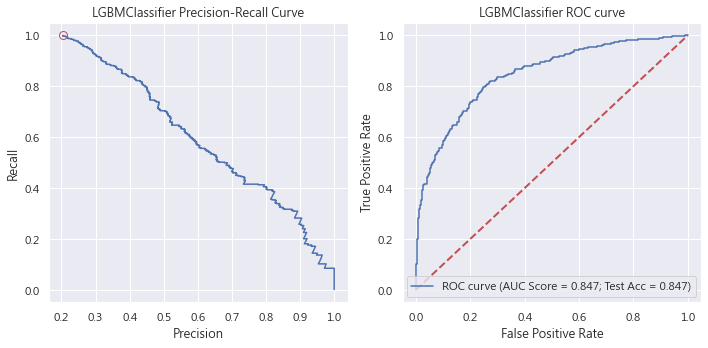

In [11]:
lgb_confusion_matrix, lgb_model= model(LGBMClassifier(n_estimators=800,random_state = 0), 'LGBMClassifier',X_train,y_train,X_test,y_test)

# 以「精準行銷模型」評估預期獲利
本節以將以數學模型融合財務指標來評估預期獲利


![](https://imgur.com/KD8d4HM.png)


![](https://imgur.com/cm6BedX.png)


![](https://imgur.com/QHHiLL6.png)

## 隨機森林獲利計算

In [12]:
rf_confusion_matrix

array([[1528,   67],
       [ 193,  212]])

In [13]:
# profit：每次銷售產品利潤
profit = 3616
cost = -500

# 在全市場，客戶真實會購買的機率
p_P = (rf_confusion_matrix[1,:].sum()) / rf_confusion_matrix.sum()

#  在全市場，客戶真實不會購買的機率
p_N = 1- p_P

# 在p_P下，預測客戶會購買的期望獲利與成本
p_P_profit = (rf_confusion_matrix[1,1]/rf_confusion_matrix[1,:].sum()) 
p_P_cost = 1-p_P_profit


# 在p_N下，預測客戶會不會購買的期望獲利與成本
p_N_profit = (rf_confusion_matrix[0,0]/rf_confusion_matrix[0,:].sum()) 
p_N_cost = 1-p_N_profit

In [14]:
rf_profit_each_customer = p_P * (profit * p_P_profit + 0 * p_P_cost)+ p_N * (0 * p_N_profit + cost * p_N_cost )

In [15]:
rf_profit_each_customer

366.546


![](https://imgur.com/N8lJn5r.png)

## XGBoost（XGB）獲利計算

In [16]:
# import contract_analysis_function
# import importlib
# importlib.reload(contract_analysis_function)

In [17]:
# 使用寫好的function來進行獲利計算
from contract_analysis_function import predicted_profit_calculation

xgb_profit_each_customer = predicted_profit_calculation(profit = 3616, cost = -500,model_confusion_matrix = xgb_confusion_matrix)

In [18]:
xgb_profit_each_customer

366.85400000000004

In [19]:
xgb_confusion_matrix

array([[1522,   73],
       [ 192,  213]])

![](https://imgur.com/jSCI2S1.png)
![](https://imgur.com/tfhdEY0.png)

## LightGBM（LGBM）

In [20]:
lgb_profit_each_customer = predicted_profit_calculation(profit = 3616, cost = -500,model_confusion_matrix = lgb_confusion_matrix)

In [21]:
lgb_profit_each_customer

345.44800000000004

![a](https://imgur.com/t47LH05.png)
